### 🚀 Open this Tutorial in Google Colab  
<a target="_blank" href="https://colab.research.google.com/github/amirhszd/MachineLearning4RemoteSensing/blob/main/hw5/hw5_p1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

###Mount Google Drive and Load Data

In this step, you’ll mount your Google Drive so that you can access .npy files directly from it. Then, load your training, validation, and test sets using NumPy. Be sure to update the paths to point to your own data files.

Make sure to set to runtime session to use GPU otherwise your training is going to be slow.

In [ ]:
# import files and mount google drive
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# Step 1: Load your .npy files from your Google Drive
# TODO: Replace the paths below with the correct paths to your own files
folderPath = '/content/drive/MyDrive/Imaging Science MS/Applied ML for Remote Sensing/Homework/HW5 - Neural Networks/Problem 1/data/'
X_train = np.load(folderPath + 'landis_chlorophyl_regression_train.npy')
y_train = np.load(folderPath + 'landis_chlorophyl_regression_traingt.npy')

X_val = np.load(folderPath + 'landis_chlorophyl_regression_val.npy')
y_val = np.load(folderPath + 'landis_chlorophyl_regression_valgt.npy')

X_test = np.load(folderPath + 'landis_chlorophyl_regression_test.npy')
y_test = np.load(folderPath + 'landis_chlorophyl_regression_testgt.npy')

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training set shape: (6000, 425)
Validation set shape: (2000, 425)
Test set shape: (2000, 425)


Wavelength shape: (425,)


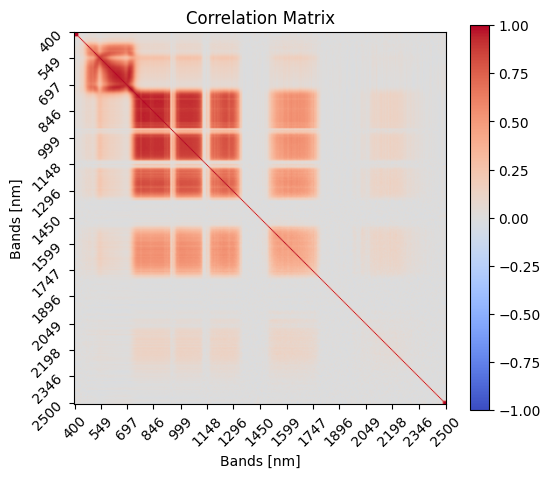

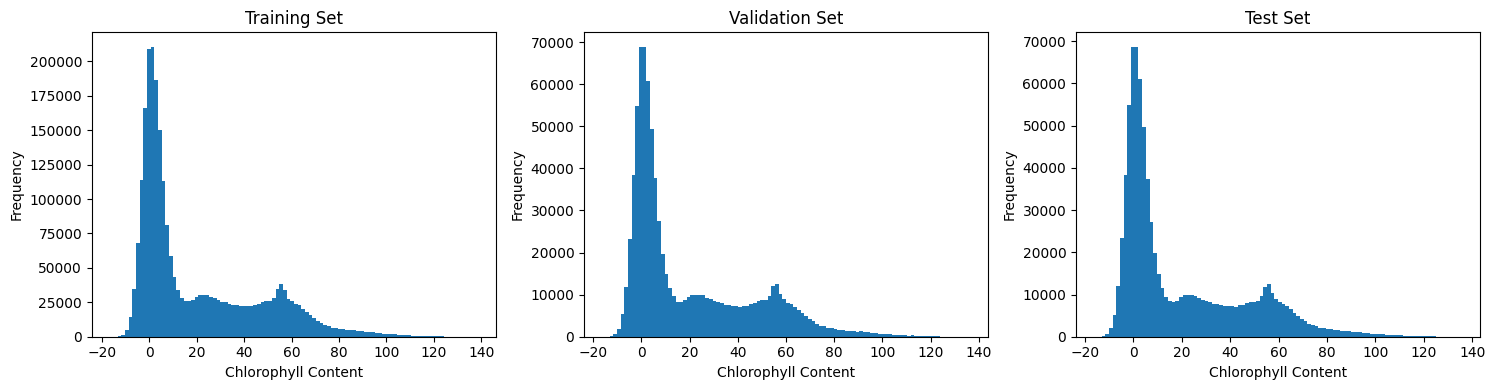

In [ ]:
# EXPLORATORY DATA ANALYSIS
from scipy.stats import skew
from scipy.stats import kurtosis
import matplotlib.pyplot as plt


# ----------- Calculate Band Statistics Function----------
def calculate_band_statistics(data):

    if len(data.shape) > 2:
        data = data.reshape(-1, data.shape[2])

    data_mean = np.mean(data,axis=0)
    data_std = np.std(data,axis=0)
    data_min = np.min(data,axis=0)
    data_max = np.max(data,axis=0)
    data_q1 = np.percentile(data,25,axis=0)
    data_median = np.median(data,axis=0)
    data_q3 = np.percentile(data,75,axis=0)
    data_skew = skew(data,axis=0)
    data_kurt = kurtosis(data,axis=0)

    stats = np.vstack([data_mean,data_std,data_min,data_max,data_q1,data_median,data_q3,data_skew,data_kurt]).T

    return stats


  # ----------------Correlation Function--------------------
def correlation_matrix(data,wl,stats):

    # reshape data where rows and pixels and cols are bands
    if len(data.shape) > 2:
        reshaped_data = data.reshape(-1, data.shape[2])
    else:
        reshaped_data = data

    # Calculate the covariance matrix between each band
    cor = np.zeros((reshaped_data.shape[1],reshaped_data.shape[1]))

    for i in range(reshaped_data.shape[1]):
        for j in range(reshaped_data.shape[1]):
            cor[i,j] = ((np.sum((reshaped_data[:,i] - stats[i,0]) * (reshaped_data[:,j] - stats[j,0]))) / reshaped_data.shape[0]) / (stats[i,1]*stats[j,1])

    # Round to 3 decimal places
    cor_format = np.round(cor, 3)

    # Display the array as a heatmap
    fig, ax = plt.subplots(figsize=(6,5))
    cax = ax.imshow(cor_format, cmap='coolwarm',vmin=-1, vmax=1)

    # Add a colorbar
    plt.colorbar(cax)

    # Set evenly spaced tick locations
    # Dynamically adjust the number of ticks based on the matrix size
    max_ticks = 15  # Maximum number of ticks to display
    num_bands = cor_format.shape[0]  # Number of spectral bands

    # Dont set more ticks than available bands
    num_ticks = min(max_ticks, num_bands)

    # Generate tick positions dynamically
    tick_positions = np.linspace(0, num_bands - 1, num=num_ticks, dtype=int)
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)

    # Set labels corresponding to selected tick positions
    ax.set_xticklabels([f"{wl[i]:.0f}" for i in tick_positions], rotation=45)
    ax.set_yticklabels([f"{wl[i]:.0f}" for i in tick_positions], rotation=45)

    plt.title("Correlation Matrix")
    plt.xlabel("Bands [nm]")
    plt.ylabel("Bands [nm]")
    plt.show()

    return cor

#-------------------------------------------------------------------------------

# Wavelength
wl = np.linspace(0.4,2.5,X_train.shape[1]) * 1000
print("Wavelength shape:",wl.shape)

# Calculate band statistics
stats = calculate_band_statistics(X_train)

# Show correlation matrix
cor = correlation_matrix(X_train,wl,stats)

# Plot histogram of each partition
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].hist(X_train.flatten(),bins=100)
ax[0].set_title("Training Set")
ax[0].set_xlabel("Chlorophyll Content")
ax[0].set_ylabel("Frequency")
ax[1].hist(X_val.flatten(),bins=100)
ax[1].set_title("Validation Set")
ax[1].set_xlabel("Chlorophyll Content")
ax[1].set_ylabel("Frequency")
ax[2].hist(X_test.flatten(),bins=100)
ax[2].set_title("Test Set")
ax[2].set_xlabel("Chlorophyll Content")
ax[2].set_ylabel("Frequency")
plt.tight_layout()
plt.show()


### Standardize the Data & Create Dataset

Here, you will standardize your dataset using StandardScaler. This ensures that each feature has zero mean and unit variance. Remember to fit the scaler only on the training data, and then transform all splits using that same scaler.

You’ll define a custom PyTorch Dataset to wrap your data and make it compatible with DataLoader. After that, instantiate the datasets and set up data loaders with appropriate batch size and parallel loading settings (num_workers, prefetch_factor).

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

# Step 1: Standard scaling based on training data only
# TODO: Scale your validation and test sets using statistics from the training set only

scaler = StandardScaler() # initialize the scaler
scaler.fit(X_train) # fit to only the training data
X_train_scaled = scaler.transform(X_train) # scale training data
X_val_scaled = scaler.transform(X_val) # scale validation data
X_test_scaled = scaler.transform(X_test) # scale test data

# Target (y) scaling
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()



# Step 2: Create custom dataset class
class ChlorophyllDataset(Dataset):
    def __init__(self, X, y):
      # TODO: Convert your numpy arrays to torch tensors with the correct dtype
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Step 3: Instantiate your datasets
train_dataset = ChlorophyllDataset(X_train_scaled, y_train_scaled)
val_dataset = ChlorophyllDataset(X_val_scaled, y_val_scaled)
test_dataset = ChlorophyllDataset(X_test_scaled, y_test_scaled)

# Step 4: Create DataLoaders
# TODO: Set batch_size, num_workers, and prefetch_factor based on your system
from torch.utils.data import DataLoader
batch_size = 64
num_workers = 2
prefetch_factor = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True,prefetch_factor=prefetch_factor)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True,prefetch_factor=prefetch_factor)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True,prefetch_factor=prefetch_factor)

print("train dataset size is:", len(train_dataset))
print("val dataset size is:", len(val_dataset))
print("test dataset size is:", len(test_dataset))


train dataset size is: 6000
val dataset size is: 2000
test dataset size is: 2000


### Define Your 1D Convolutional Model
In this step, you’ll define a custom SpectralCNN model using PyTorch’s nn Module. This model consists of a sequence of 1D convolutional layers with increasing filter sizes and stride to reduce the spectral dimension. The final Linear layer maps the learned features to a single output value for regression.

💡 Note: Since your input has shape [batch_size, 425], you’ll need to change the shape accordingly.

In [ ]:

import torch.nn as nn

class SpectralCNN(nn.Module):
    def __init__(self):
        super(SpectralCNN, self).__init__()
        # 8 layer 1D CNN with kernel size 3 and stride of 2
        # stride 2 lowers the dimensionality spectral dimensionality
        # relu is the activation function introducing nonlinearity
        # the bigger the kernel size the more number of parameters to learn
        self.net = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, stride=2), nn.ReLU(),  # [B, 8, 212]
            nn.Conv1d(8, 16, kernel_size=3, stride=2), nn.ReLU(), # [B, 16, 105]
            nn.Conv1d(16, 32, kernel_size=3, stride=2), nn.ReLU(),# [B, 32, 52]
            nn.Conv1d(32, 64, kernel_size=3, stride=2), nn.ReLU(),# [B, 64, 25]
            nn.Conv1d(64, 128, kernel_size=3, stride=2), nn.ReLU(),# [B, 128, 12]
            nn.Conv1d(128, 128, kernel_size=3, stride=2), nn.ReLU(),# [B, 128, 5]
            nn.Conv1d(128, 256, kernel_size=3, stride=2), nn.ReLU(),# [B, 256, 2]
            nn.Conv1d(256, 256, kernel_size=2, stride=1), nn.ReLU(),# [B, 256, 1]
            nn.Flatten(),
            # we are performing regression so output is one value
            nn.Linear(256, 1)
        )

    def forward(self, x):

        # TODO: x is of size Nx425, however, we need to define the number of channels for our 1D data
        # in this case there is only 1 channel/feature for our 425 input features
        # in 2D space we have N x C_in x H x W.
        # in 1D space we should have N x C_in x Length
        # modify the retun correctly to reflect this
        x = x.unsqueeze(1) # make channels for each feature
        return self.net(x)



### Define the Model, Optimizer, and Training Configuration

In this section, you will define the loss function for your regression task, instantiate your model, and set up the optimizer of your choice. Make sure to use weight decay to prevent overfitting.

Your training will benefit from learning rate scheduler such as to gradually reduce the learning rate during training. Finally, you’ll move your model to the GPU if available.

💡 Tip: Your learning rate and weight decay are hyperparameters!

In [ ]:
# TODO: Define regression LOSS
criterion = nn.MSELoss()

# instantiating the model
model = SpectralCNN()

# TODO: define optimizer, suggestion is on Adam with weight decay.
# keep in mind weight decay and learning rate are hyperpareters
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8,weight_decay=1e-5)

# TODO: you can define a learning rate scheduler at the time of training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Optional: use GPU if available
# make sure to change your runtime type to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using:", device)

NameError: name 'nn' is not defined

### Training Loop and Early Stopping

In this section, you will implement the full training loop for your model. For each epoch, you’ll:

	•	Loop through your training data
	•	Send batches to the correct device
	•	Perform forward and backward passes
	•	Update the model using your optimizer

After training on each epoch, you’ll evaluate your model on the validation set without computing gradients. You’ll track the best-performing model based on validation loss and save it using torch.save(). Finally, you’ll step the learning rate scheduler to gradually reduce the learning rate over time.

Make sure to plot loss for training and validation sets, this will help you see into overfitting and underfitting.

🛑 Don’t forget: only update weights during training, and use torch.no_grad() during validation to save memory and speed up evaluation.

In [ ]:

# Initialize variables for early stopping
best_val_loss = float("inf")
best_epoch = -1

# keeping track of validation loss
val_loss_history = []
train_loss_history = []

# For early stopping
no_improvement = 0

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_losses = []

    # TOOD: keep track of any other regression metric you want per

    for X_batch, y_batch in train_loader:
        # TODO: send input features and reference target to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # zeroing out previous step gradients
        optimizer.zero_grad()

        # make a prediction using the model
        outputs = model(X_batch)

        # TODO: calculate the loss
        loss = criterion(outputs, y_batch)

        # TODO: calculate the gradients by calling backward on the loss
        loss.backward()

        # TODO: take a step by calling step on the optimizer
        optimizer.step()

        # TODO: keep score of your training loss and any other metric you see fit for
        # your regression task
        train_losses.append(loss.item())

    train_loss_mean = np.mean(train_losses)
    train_loss_history.append(train_loss_mean)

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # TODO: Same as training but we are not updating weights
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            val_loss = criterion(outputs, y_batch)
            val_losses.append(val_loss.item())

    # TODO: implementing early stopping here.
    # keep track of the validation loss and save the model parameters
    # when the loss is the lowest for the validation set
    val_loss_mean = np.mean(val_losses)
    val_loss_history.append(val_loss_mean)
    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pt")
        no_improvement = 0
    else:
      no_improvement = no_improvement + 1
      if no_improvement >= 10:
        print(f"\nEarly stopping triggered after {best_epoch+1} epochs")
        break


    # TODO: take a step in the scheduler to update the learning rate
    scheduler.step()

    # Print summary
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {val_loss_mean:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

print(f"\nBest model saved from epoch {best_epoch+1} with Val Loss: {best_val_loss:.4f}")


### Get predictions and plot your results
Get predictions on your test set and plot your regression results for your training and test set.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, '.-',label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation loss
plt.plot(val_loss_history, 'g.-',label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# TODO: we are to check the model's performance on the validation set
# load the "best_model.pt" and pass your test data to it and get predictions
# make sure the model is in eval mode, send the data to device
# note: make sure you handled "shuffle" properly in your validation/testing set

# loading the best model
model.load_state_dict(torch.load("best_model.pt", weights_only=True))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch).squeeze()
            all_preds.append(preds.cpu())
            all_targets.append(y_batch.cpu())

# concatenate everything
y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_targets).numpy()

# Unscale predictions and targets before evaluation
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()


#TODO: plot regression plot and residual plots for your regression task,
# report R2, and MAE along with any other metrics you want
# analyze your results and report on your findings.

print("Size of predicted and true",y_pred.shape, y_true.shape)

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
residuals = y_true - y_pred
std_residuals = np.std(residuals)

# Plot results on validation data
fig,ax = plt.subplots(1,2,figsize=(15,4))
# Regression Plot
ax[0].scatter(y_true, y_pred, alpha=0.5,edgecolors='black')
ax[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
ax[0].set_xlabel('Actual Chlorophyll Content')
ax[0].set_ylabel('Predicted Chlorophyll Content')
ax[0].set_title('Regression Plot')
textstr = f"MAE: {mae:.2f}\nR²: {r2:.2f}"
ax[0].text(0.05, 0.95, textstr,
           transform=ax[0].transAxes,
           verticalalignment='top',
           horizontalalignment='left',
           fontsize=10)

# Residuals Plot
ax[1].scatter(y_pred, residuals, color='g',alpha=0.5,edgecolors='black')
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residual Plot")
textstr = f"Std Residuals: {std_residuals:.2f}"
ax[1].text(0.05, 0.95, textstr,
           transform=ax[1].transAxes,
           verticalalignment='top',
           horizontalalignment='left',
           fontsize=10)

plt.tight_layout()
plt.suptitle('Validation Data',fontsize=12,fontweight='bold')
plt.show()


print("MAE:", mean_absolute_error(y_true, y_pred))
print("R2 Score:", r2_score(y_true, y_pred))
print("Std Residuals:", std_residuals)


I am attaching the test results from Xgboost here for your reference! Your tuned model should outpefrom this performance:

MAE=3.22, R2=0.96

![xgboost](xgboost.png)

### Hyperparamter Tuning
This part is all you. You have a base model that is performing somewhat accurately for you. Grab a package and perform hyperparameter tuning on your hyperparameters. Read Below!!!

In [ ]:
# TODO: now that we have a base model that things are working, we perform hyperparameter tuning on validation data

# change the learning rate value
# number of layers
# filter size (the bigger the filter size the more computationally expensive)
# instead of ReLU use leaky Relu or Tanh
# learning weight decay

# using max/average pooling instead of stride 2

# icorporating padding
# you can log the lowest loss (highest accuracy) on your validation set and report that


In [ ]:
import optuna
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_absolute_error

input_size = X_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define a new version of our custom class with tunable hyperparameters
class SpectralCNN(nn.Module):
    def __init__(self, input_size, num_layers=8, base_channels=8, kernel_size=3,stride=1,padding=1,activation=nn.ReLU,pooling=nn.AvgPool1d):
        super(SpectralCNN, self).__init__()

        layers = [] # dynamic layer size
        in_channels = 1 # input
        out_channels = base_channels # first output

        # Create a new layer for the number of defined layers
        for i in range(num_layers):
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,padding=padding))
            layers.append(activation()) # tunable activation function
            layers.append(pooling(kernel_size=2, stride=2)) # pooling

            # follow the same in/out structure as original class
            in_channels = out_channels
            out_channels *= 2

        # layers.append(nn.Flatten()) # flatten the features for the fully connected layer

        self.features = nn.Sequential(*layers) # pass the final list of model layers


        # Create a dummy input to figure out final flattened size
        with torch.no_grad():
          dummy_input = torch.zeros(1, 1, input_size)  # (batch=1, channel=1, length=input_size)
          dummy_output = self.features(dummy_input)
          self.num_features = dummy_output.view(1, -1).shape[1]  # flatten and get the feature size


        # Use the final out_channels from the last layer
        # self.regressor = nn.Linear(in_channels, 1)
        self.regressor = nn.Linear(self.num_features, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # add the channel dimension
        x = self.features(x)  # after all convolutions + pooling
        x = x.view(x.size(0), -1)  # flatten before regressor
        return self.regressor(x)  # final regression output


In [ ]:
# Function for training and validation during the hyperparameter tuning
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5):

  # ----------------------- Training loop ----------------------------
      for epoch in range(num_epochs):  # start with few epochs for speed
          model.train() # set model to training mode
          for X_batch, y_batch in train_loader: # use our training data
              X_batch, y_batch = X_batch.to(device), y_batch.to(device) # send to device
              optimizer.zero_grad() # reset the gradient
              outputs = model(X_batch) # make predictions
              loss = criterion(outputs, y_batch) # calculate loss
              loss.backward() # backpropogation
              optimizer.step() # make a step

      #-------------------------- Validation -----------------------------
      model.eval() # set model to evaluation mode
      val_losses = [] # initialize validation loss
      with torch.no_grad(): # do not track gradients
          for X_batch, y_batch in val_loader: # use validation data
              X_batch, y_batch = X_batch.to(device), y_batch.to(device) # send to device
              outputs = model(X_batch) # make predictions
              loss = criterion(outputs, y_batch) # calculate loss
              val_losses.append(loss.item()) # store the loss for each minibatch
      avg_val_loss = np.mean(val_losses) # average the validation loss
      return avg_val_loss


In [ ]:
# ------------------------- TUNE THE LEARNING RATE -----------------------------

# Define an objective function only varying the learning rate
def objective_lr(trial):
    # Fix random seed
    torch.manual_seed(15)
    np.random.seed(15)

    # Start with a range of learning rates
    lr = trial.suggest_float("lr", 1e-5, 1e-2,log=True) # sample learning rates on log scale

    # Initialize our spectral 1D CNN model
    model = SpectralCNN(input_size=input_size).to(device)

    # Set adam optimizer using the learning rates under trial
    optimizer = Adam(model.parameters(), lr=lr)

    # Use MSE as the loss metric
    criterion = nn.MSELoss()

    # Train and calculate validation loss
    return train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10)
#===============================================================================

# Create Optuna study to minimize the loss
study = optuna.create_study(direction="minimize")

# Optimize using the objective funtion with different learning rates
study.optimize(objective_lr, n_trials=10)

# Print the best learning rate
best_lr = study.best_params["lr"]
print("Best learning rate:", best_lr)

# Print the best validation loss
print("Best validation loss:", study.best_value)

[I 2025-04-26 16:00:08,208] A new study created in memory with name: no-name-d9a3ac98-ed80-4d59-9c70-155d800e481e
[I 2025-04-26 16:00:18,404] Trial 0 finished with value: 0.060433168429881334 and parameters: {'lr': 7.208145916511198e-05}. Best is trial 0 with value: 0.060433168429881334.
[I 2025-04-26 16:00:28,188] Trial 1 finished with value: 0.07135312270838767 and parameters: {'lr': 4.542607419324789e-05}. Best is trial 0 with value: 0.060433168429881334.
[I 2025-04-26 16:00:38,056] Trial 2 finished with value: 0.06534025655128062 and parameters: {'lr': 0.0014076412153372854}. Best is trial 0 with value: 0.060433168429881334.
[I 2025-04-26 16:00:48,145] Trial 3 finished with value: 0.047702800191473216 and parameters: {'lr': 0.00010044887350284299}. Best is trial 3 with value: 0.047702800191473216.
[I 2025-04-26 16:00:58,113] Trial 4 finished with value: 0.22864795522764325 and parameters: {'lr': 1.0147694288266037e-05}. Best is trial 3 with value: 0.047702800191473216.
[I 2025-04-2

Best learning rate: 0.00325482744949447
Best validation loss: 0.035171569033991545


In [ ]:
# ------------------------- TUNE THE NUMBER OF LAYERS -----------------------------

# Define an objective function only varying the layer size
def objective_ls(trial):
    # Fix random seed
    torch.manual_seed(15)
    np.random.seed(15)

    # # Set a range for number of layers
    num_layers = trial.suggest_int("num_layers", 4, 7)

    # Initialize our spectral 1D CNN model
    model = SpectralCNN(input_size=input_size,num_layers=num_layers).to(device)

    # Set adam optimizer using the learning rates under trial
    optimizer = Adam(model.parameters(), lr=best_lr)

    # Use MSE as the loss metric
    criterion = nn.MSELoss()

    # Train and calculate validation loss
    return train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)

#===============================================================================

# Create Optuna study to minimize the loss
study = optuna.create_study(direction="minimize")

# Optimize using the objective funtion with different layer sizes
study.optimize(objective_ls, n_trials=10)

# Print the best layer size
best_ls = study.best_params["num_layers"]
print("Best number of layers:", best_ls)

# Print the best validation loss
print("Best validation loss:", study.best_value)

[I 2025-04-26 16:12:38,952] A new study created in memory with name: no-name-ae3eb9b2-4686-4d87-9b55-dfa2ae0e26af
[I 2025-04-26 16:13:02,307] Trial 0 finished with value: 0.05316080118063837 and parameters: {'num_layers': 4}. Best is trial 0 with value: 0.05316080118063837.
[I 2025-04-26 16:13:17,475] Trial 1 finished with value: 0.05316080118063837 and parameters: {'num_layers': 4}. Best is trial 0 with value: 0.05316080118063837.
[I 2025-04-26 16:13:46,629] Trial 2 finished with value: 0.033245498983887956 and parameters: {'num_layers': 6}. Best is trial 2 with value: 0.033245498983887956.
[I 2025-04-26 16:14:02,688] Trial 3 finished with value: 0.05316080118063837 and parameters: {'num_layers': 4}. Best is trial 2 with value: 0.033245498983887956.
[I 2025-04-26 16:14:24,292] Trial 4 finished with value: 0.03410362469730899 and parameters: {'num_layers': 5}. Best is trial 2 with value: 0.033245498983887956.
[I 2025-04-26 16:15:15,234] Trial 5 finished with value: 0.03314966190373525 

Best number of layers: 7
Best validation loss: 0.03314966190373525


In [ ]:
# ------------------------- TUNE THE FILTER SIZE -----------------------------

# Define an objective function only varying the filter size
def objective_fs(trial):
    # Fix random seed
    torch.manual_seed(15)
    np.random.seed(15)

    # Set a range for kernel sizes
    kernel_size = trial.suggest_int("kernel_size", 2,5)

    # Initialize our spectral 1D CNN model (set padding=2 to use larger filters)
    model = SpectralCNN(input_size=input_size,num_layers=best_ls,kernel_size=kernel_size,padding=2).to(device)

    # Set adam optimizer using the learning rates under trial
    optimizer = Adam(model.parameters(), lr=best_lr)

    # Use MSE as the loss metric
    criterion = nn.MSELoss()

    # Train and calculate validation loss
    return train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)

#===============================================================================

# Create Optuna study to minimize the loss
study = optuna.create_study(direction="minimize")

# Optimize using the objective funtion with different filter sizes
study.optimize(objective_fs, n_trials=5)

# Print the best filter size
best_fs = study.best_params["kernel_size"]
print("Best filter size:", best_fs)

# Print the best validation loss
print("Best validation loss:", study.best_value)

[I 2025-04-26 16:19:18,652] A new study created in memory with name: no-name-a34cb4bb-0154-411e-886b-42b4f91c68cc
[I 2025-04-26 16:20:22,337] Trial 0 finished with value: 0.028443461924325675 and parameters: {'kernel_size': 4}. Best is trial 0 with value: 0.028443461924325675.
[I 2025-04-26 16:21:25,447] Trial 1 finished with value: 0.04209551343228668 and parameters: {'kernel_size': 5}. Best is trial 0 with value: 0.028443461924325675.
[I 2025-04-26 16:22:23,992] Trial 2 finished with value: 0.04598019027616829 and parameters: {'kernel_size': 3}. Best is trial 0 with value: 0.028443461924325675.
[I 2025-04-26 16:23:23,465] Trial 3 finished with value: 0.04598019027616829 and parameters: {'kernel_size': 3}. Best is trial 0 with value: 0.028443461924325675.
[I 2025-04-26 16:24:25,320] Trial 4 finished with value: 0.028443461924325675 and parameters: {'kernel_size': 4}. Best is trial 0 with value: 0.028443461924325675.


Best filter size: 4
Best validation loss: 0.028443461924325675


In [ ]:
# ------------------------- TUNE THE ACTIVATION FUNCTION -----------------------------

# Define an objective function only varying the activation function
def objective_af(trial):
    # Fix random seed
    torch.manual_seed(15)
    np.random.seed(15)

    # Set a range for activation functions
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "Tanh"])

    activation_fn = {
      "ReLU": nn.ReLU,
      "LeakyReLU": nn.LeakyReLU,
      "Tanh": nn.Tanh
    }[activation_name]

    # Initialize our spectral 1D CNN model
    model = SpectralCNN(input_size=input_size,num_layers=best_ls,kernel_size=best_fs,padding=2,activation=activation_fn).to(device)

    # Set adam optimizer using the learning rates under trial
    optimizer = Adam(model.parameters(), lr=best_lr)

    # Use MSE as the loss metric
    criterion = nn.MSELoss()

    # Train and calculate validation loss
    return train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)

#===============================================================================

# Create Optuna study to minimize the loss
study = optuna.create_study(direction="minimize")

# Optimize using the objective funtion with different activation functions
study.optimize(objective_af, n_trials=5)

# Print the best activation function
best_activation = study.best_params["activation"]
print("Best activation function:", best_activation)

# Print the best validation loss
print("Best validation loss:", study.best_value)

[I 2025-04-26 16:25:59,336] A new study created in memory with name: no-name-1d9c6fdf-89c7-4388-947b-41f0f9aaf648
[I 2025-04-26 16:27:02,690] Trial 0 finished with value: 0.046025636489503086 and parameters: {'activation': 'Tanh'}. Best is trial 0 with value: 0.046025636489503086.
[I 2025-04-26 16:28:06,538] Trial 1 finished with value: 0.041557984019163996 and parameters: {'activation': 'Tanh'}. Best is trial 1 with value: 0.041557984019163996.
[I 2025-04-26 16:29:09,005] Trial 2 finished with value: 0.07415569794829935 and parameters: {'activation': 'ReLU'}. Best is trial 1 with value: 0.041557984019163996.
[I 2025-04-26 16:30:11,112] Trial 3 finished with value: 0.02732573391404003 and parameters: {'activation': 'ReLU'}. Best is trial 3 with value: 0.02732573391404003.
[I 2025-04-26 16:31:14,659] Trial 4 finished with value: 0.03705375432036817 and parameters: {'activation': 'Tanh'}. Best is trial 3 with value: 0.02732573391404003.


Best activation function: ReLU
Best validation loss: 0.02732573391404003


In [ ]:
# ------------------------- TUNE THE WEIGHT DECAY -----------------------------

# Define an objective function only varying the weight decay
def objective_wd(trial):
    # Fix random seed
    torch.manual_seed(15)
    np.random.seed(15)

    # Set a range for weight decay
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2,log=True)

    activation_fn = {
      "ReLU": nn.ReLU,
      "LeakyReLU": nn.LeakyReLU,
      "Tanh": nn.Tanh
    }[best_activation]

    # Initialize our spectral 1D CNN model
    model = SpectralCNN(input_size=input_size,num_layers=best_ls,kernel_size=best_fs,padding=2,activation=activation_fn).to(device)

    # Set adam optimizer using the learning rates under trial
    optimizer = Adam(model.parameters(), lr=best_lr,weight_decay=weight_decay)

    # Use MSE as the loss metric
    criterion = nn.MSELoss()

    # Train and calculate validation loss
    return train_and_validate(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)

#===============================================================================

# Create Optuna study to minimize the loss
study = optuna.create_study(direction="minimize")

# Optimize using the objective funtion with different weight decay
study.optimize(objective_wd, n_trials=5)

# Print the best activation function
best_wd = study.best_params["weight_decay"]
print("Best weight decay:", best_wd)

# Print the best validation loss
print("Best validation loss:", study.best_value)

[I 2025-04-26 16:34:31,070] A new study created in memory with name: no-name-e0beb0b6-d3ef-45ff-947e-c95a271a5b7e
[I 2025-04-26 16:35:34,769] Trial 0 finished with value: 0.03221944160759449 and parameters: {'weight_decay': 1.2499826435342436e-05}. Best is trial 0 with value: 0.03221944160759449.
[I 2025-04-26 16:36:36,704] Trial 1 finished with value: 0.07036904327105731 and parameters: {'weight_decay': 0.006480405505606321}. Best is trial 0 with value: 0.03221944160759449.
[I 2025-04-26 16:37:39,769] Trial 2 finished with value: 0.05559122411068529 and parameters: {'weight_decay': 0.0045051524630110125}. Best is trial 0 with value: 0.03221944160759449.
[I 2025-04-26 16:38:42,462] Trial 3 finished with value: 0.03218970980378799 and parameters: {'weight_decay': 0.0010441322226827912}. Best is trial 3 with value: 0.03218970980378799.
[I 2025-04-26 16:39:43,779] Trial 4 finished with value: 0.026016359915956855 and parameters: {'weight_decay': 2.1472347495004865e-06}. Best is trial 4 wi

Best weight decay: 2.1472347495004865e-06
Best validation loss: 0.026016359915956855


In [ ]:
# define regression loss
criterion = nn.MSELoss()

# instantiating the model with tuned hyperparameters
model = SpectralCNN(input_size=input_size,num_layers=best_ls,kernel_size=best_fs,padding=2,activation=nn.ReLU)

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=best_wd)

# you can define a learning rate scheduler at the time of training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using:", device)

Using: cpu


Epoch 1/50 | Train Loss: 0.2732 | Val Loss: 0.0947 | LR: 0.003255
Epoch 2/50 | Train Loss: 0.0701 | Val Loss: 0.0608 | LR: 0.003255
Epoch 3/50 | Train Loss: 0.0543 | Val Loss: 0.0426 | LR: 0.003255
Epoch 4/50 | Train Loss: 0.0440 | Val Loss: 0.0462 | LR: 0.003255
Epoch 5/50 | Train Loss: 0.0360 | Val Loss: 0.0281 | LR: 0.003255
Epoch 6/50 | Train Loss: 0.0339 | Val Loss: 0.0284 | LR: 0.003255
Epoch 7/50 | Train Loss: 0.0351 | Val Loss: 0.0277 | LR: 0.003255
Epoch 8/50 | Train Loss: 0.0307 | Val Loss: 0.0314 | LR: 0.003255
Epoch 9/50 | Train Loss: 0.0292 | Val Loss: 0.0286 | LR: 0.003255
Epoch 10/50 | Train Loss: 0.0299 | Val Loss: 0.0279 | LR: 0.000325
Epoch 11/50 | Train Loss: 0.0230 | Val Loss: 0.0224 | LR: 0.000325
Epoch 12/50 | Train Loss: 0.0222 | Val Loss: 0.0231 | LR: 0.000325
Epoch 13/50 | Train Loss: 0.0218 | Val Loss: 0.0221 | LR: 0.000325
Epoch 14/50 | Train Loss: 0.0217 | Val Loss: 0.0217 | LR: 0.000325
Epoch 15/50 | Train Loss: 0.0217 | Val Loss: 0.0221 | LR: 0.000325
Epoc

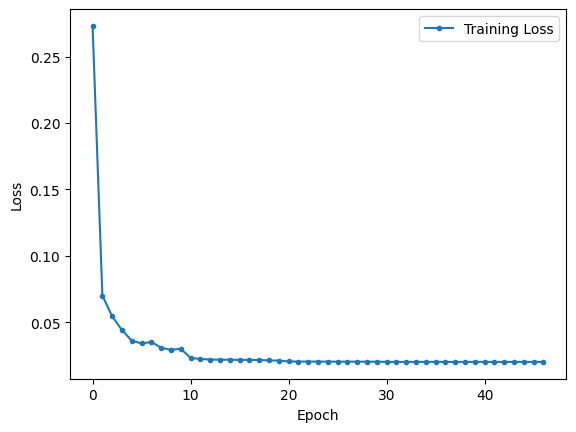

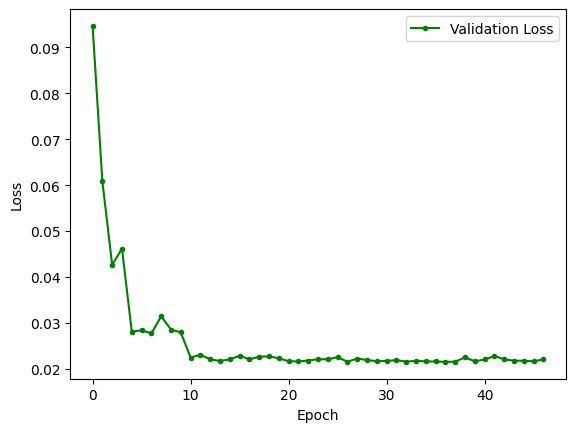

In [ ]:
# ----------------- TRAIN MODEL WITH TUNED HYPERPARAMETERS --------------------

# Initialize variables for early stopping
best_val_loss = float("inf")
best_epoch = -1

# keeping track of validation loss
val_loss_history = []
train_loss_history = []

# For early stopping
no_improvement = 0

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_losses = []

    # TOOD: keep track of any other regression metric you want per

    for X_batch, y_batch in train_loader:
        # TODO: send input features and reference target to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # zeroing out previous step gradients
        optimizer.zero_grad()

        # send input features and reference target to device
        outputs = model(X_batch)

        # TODO: calculate the loss
        loss = criterion(outputs, y_batch)

        # TODO: calculate the gradients by calling backward on the loss
        loss.backward()

        # TODO: take a step by calling step on the optimizer
        optimizer.step()

        # TODO: keep score of your training loss and any other metric you see fit for
        # your regression task
        train_losses.append(loss.item())

    train_loss_mean = np.mean(train_losses)
    train_loss_history.append(train_loss_mean)

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # TODO: Same as training but we are not updating weights
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            val_loss = criterion(outputs, y_batch)
            val_losses.append(val_loss.item())

    # TODO: implementing early stopping here.
    # keep track of the validation loss and save the model parameters
    # when the loss is the lowest for the validation set
    val_loss_mean = np.mean(val_losses)
    val_loss_history.append(val_loss_mean)
    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pt")
        no_improvement = 0
    else:
      no_improvement = no_improvement + 1
      if no_improvement >= 10:
        print(f"\nEarly stopping triggered after {best_epoch+1} epochs")
        break


    # TODO: take a step in the scheduler to update the learning rate
    scheduler.step()

    # Print summary
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {val_loss_mean:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

print(f"\nBest model saved from epoch {best_epoch+1} with Val Loss: {best_val_loss:.4f}")

# ---------- PLOT TRAINING LOSS -------------
import matplotlib.pyplot as plt

plt.plot(train_loss_history, '.-',label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation loss
plt.plot(val_loss_history, 'g.-',label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

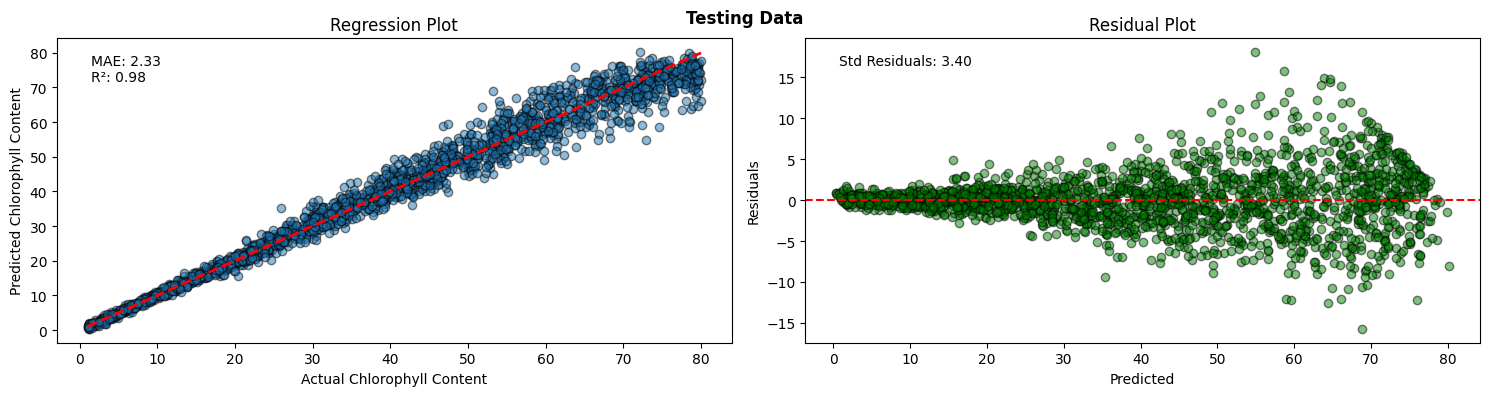

MAE: 2.33345103263855
R2 Score: 0.9777615666389465
Std Residuals: 3.402904


In [ ]:
# ---------------- TEST SET RESULTS ON OPTIMAL MODEL ----------------
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# TODO: we are to check the model's performance on the validation set
# load the "best_model.pt" and pass your test data to it and get predictions
# make sure the model is in eval mode, send the data to device
# note: make sure you handled "shuffle" properly in your validation/testing set

# loading the best model
model.load_state_dict(torch.load("best_model.pt", weights_only=True))
model.eval()

test_preds = []
test_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch).squeeze()
            test_preds.append(preds.cpu())
            test_targets.append(y_batch.cpu())

# concatenate everything
y_pred = torch.cat(test_preds).numpy()
y_true = torch.cat(test_targets).numpy()

# Unscale predictions and targets before evaluation
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()


#TODO: plot regression plot and residual plots for your regression task,
# report R2, and MAE along with any other metrics you want
# analyze your results and report on your findings.


# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
residuals = y_true - y_pred
std_residuals = np.std(residuals)

# Plot results on test data
fig,ax = plt.subplots(1,2,figsize=(15,4))
# Regression Plot
ax[0].scatter(y_true, y_pred, alpha=0.5,edgecolors='black')
ax[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
ax[0].set_xlabel('Actual Chlorophyll Content')
ax[0].set_ylabel('Predicted Chlorophyll Content')
ax[0].set_title('Regression Plot')
textstr = f"MAE: {mae:.2f}\nR²: {r2:.2f}"
ax[0].text(0.05, 0.95, textstr,
           transform=ax[0].transAxes,
           verticalalignment='top',
           horizontalalignment='left',
           fontsize=10)

# Residuals Plot
ax[1].scatter(y_pred, residuals, color='g',alpha=0.5,edgecolors='black')
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residual Plot")
textstr = f"Std Residuals: {std_residuals:.2f}"
ax[1].text(0.05, 0.95, textstr,
           transform=ax[1].transAxes,
           verticalalignment='top',
           horizontalalignment='left',
           fontsize=10)

plt.tight_layout()
plt.suptitle('Testing Data',fontsize=12,fontweight='bold')
plt.show()


print("MAE:", mean_absolute_error(y_true, y_pred))
print("R2 Score:", r2_score(y_true, y_pred))
print("Std Residuals:", np.std(residuals))
